<a href="https://colab.research.google.com/github/Hbnyoni/CHEAQI-Dynamic-Indicators/blob/main/AOD_Kenya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geehydro
!pip install rioxarray
!apt install gdal-bin python3-gdal
!pip install fiona
!pip install rasterio
!pip install folium
!pip install geemap
!pip install cartopy
!pip install mapclassify
!pip install geoplot
!pip install pyreadr
!pip install pysal
!pip install contextily
!pip install jupyterlab
!pip install geopandas
!pip install pyreadr

'apt' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
#import all libraries
import os
import numpy as np, pandas as pd
import ee
import geemap
import pyreadr
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import concurrent.futures
import pickle
import logging
import requests
from io import BytesIO
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Authenticate and initialize Earth Engine API
try:
    ee.Initialize(project='ee-cheaqi')
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [ ]:
# Check if notebook is running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
   IN_COLAB = False

In [ ]:
if IN_COLAB:
    # Use the token from Github to clone the PRECISE repository with read/write access
    from IPython.display import clear_output; user="Hbnyoni"; token=input();
    !git clone https://github.com/Hbnyoni/dynamic_indicators.git

    clear_output()

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: File /vsimem/dc7f0d40d5754460ab8bc34548640c3d has GPKG application_id, but non conformant file extension
  return ogr_read(


ROI Bounding Box: [39.07913463 -4.33528734 39.75067504 -3.70668055]
   OBJECTID  village_co          name    Field5      chu  latitude  longitude  \
0         1           0        Bambam      None    mwele -3.941202  39.571624   
1         2           0     Bara mare  Baremare     buni -3.949008  39.569109   
2         3      254001        BATANI      None  KOMBENI -3.889574  39.598271   
3         4      254002  BATANI ASILI      None  KOMBENI -3.896055  39.588316   
4         5           0        Bejana      None     Buni -3.948978  39.569095   

   accuracy  BUFF_DIST  ORIG_FID  Shape_Leng  Shape_Area  ORIG_FID_1  \
0    12.000       75.0         0    0.004250    0.000001           0   
1    32.000       75.0         1    0.004251    0.000001           1   
2    12.000       75.0         2    0.004250    0.000001           2   
3     4.873       75.0         3    0.004250    0.000001           3   
4    48.000       75.0         4    0.004251    0.000001           4   

   OBJECTID_

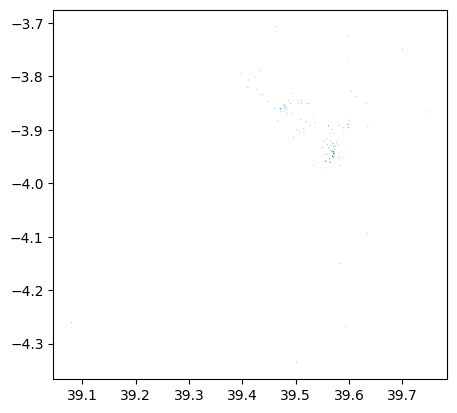

In [ ]:
# GitHub raw URL for the GeoPackage (replace with your actual link)
url = 'https://github.com/Hbnyoni/dynamic_indicators/raw/main/shapefiles1/precise_villages.gpkg'

# Download the file using requests
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the file using geopandas from the bytes content
    with BytesIO(response.content) as f:
        gdf = gpd.read_file(f, layer='Kenya')  # Update layer if necessary

    # Plot the geodataframe (optional)
    gdf.plot()

    # Get the bounding box of the shapefile
    bbox = gdf.total_bounds  # total_bounds returns [minx, miny, maxx, maxy]

    # Define the region of interest (ROI) as the bounding box of the shapefile
    roi = ee.Geometry.Rectangle([bbox[0], bbox[1], bbox[2], bbox[3]])

    # Print the bounding box for verification
    print(f"ROI Bounding Box: {bbox}")

else:
    print(f"Failed to download the file. Status code: {response.status_code}")

# Print the attribute table for reference (optional)
print(gdf.head())

In [ ]:
#Import rds file that has outdoor exposure datapoints
# Define the path to the RDS file
input_rds_path = 'C:/Users/user/OneDrive/Documents/CHEAQI-MNCH/CHEAQI Project Docs/VALIDATIN AND SEGMENTATION PRECISE DATASETS/Validation/Dynamic Indicators/AOD/Kenya/outdoor_data_Kenya.rds'

# Load the RDS file using pyreadr
result = pyreadr.read_r(input_rds_path)

# Extract the DataFrame (the object returned by pyreadr is a dictionary, we extract the first item)
outdoor_data = list(result.values())[0]

# Check if there is a 'date' column and create the 'date_only' column
if 'date' in outdoor_data.columns:
    # Convert the 'date' column to datetime format if it's not already in that format
    outdoor_data['date'] = pd.to_datetime(outdoor_data['date'], errors='coerce')

    # Create a new column 'date_only' with the date in YYYY-MM-DD format
    outdoor_data['date_only'] = outdoor_data['date'].dt.strftime('%Y-%m-%d')

# Define the output CSV path
output_csv_path = 'C:/Users/user/OneDrive/Documents/CHEAQI-MNCH/CHEAQI Project Docs/VALIDATIN AND SEGMENTATION PRECISE DATASETS/Validation/Dynamic Indicators/AOD/Kenya/outdoor_data_Kenya_with_date_only.csv'

# Save the DataFrame to a CSV file
outdoor_data.to_csv(output_csv_path, index=False)

print(f"Data with new 'date_only' column saved to {output_csv_path}")


Data with new 'date_only' column saved to C:/Users/user/OneDrive/Documents/CHEAQI-MNCH/CHEAQI Project Docs/VALIDATIN AND SEGMENTATION PRECISE DATASETS/Validation/Dynamic Indicators/AOD/Kenya/outdoor_data_Kenya_with_date_only.csv


In [ ]:
#Get AOD images from MODIS Band 2 Optical depth 047  using the dataset date range
# Initialize Earth Engine
ee.Initialize()

# Define the base directory where results will be saved
base_dir ='C:/Users/user/OneDrive/Documents/CHEAQI-MNCH/CHEAQI Project Docs/VALIDATIN AND SEGMENTATION PRECISE DATASETS/Validation/Dynamic Indicators/AOD/Kenya'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Step 1: Get the available AOD image dates for the predefined ROI
def get_available_aod_dates(start_date, end_date, roi):
    # Load MODIS AOD collection and filter by date and ROI
    collection = (ee.ImageCollection('MODIS/061/MCD19A2_GRANULES')
                  .filterDate(start_date, end_date)
                  .filterBounds(roi)
                  .select('Optical_Depth_047'))

    # Extract the unique dates with available AOD data
    available_dates = collection.aggregate_array('system:time_start').map(lambda t: ee.Date(t).format('YYYY-MM-dd')).distinct()
    available_dates = available_dates.getInfo()

    print(f"Available AOD dates: {available_dates}")
    return available_dates

# Get the available dates for a given date range
start_date = '2022-01-01'
end_date = '2023-01-31'
available_dates = get_available_aod_dates(start_date, end_date, roi)

# Save available dates to a CSV file for use in later steps
available_dates_path = os.path.join(base_dir, 'available_aod_dates.csv')
pd.DataFrame(available_dates, columns=['available_dates']).to_csv(available_dates_path, index=False)

print(f"Available AOD dates saved to: {available_dates_path}")


Available AOD dates: ['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28', '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01', '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05', '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25', '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05', '2022-03-06', '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-11'

In [ ]:
#Filter data points that hva the same image dates with the MODIS image
# Load the CSV file with the new 'date_only' column
csv_path = os.path.join(base_dir, 'outdoor_data_Kenya_with_date_only.csv')
points_df = pd.read_csv(csv_path, low_memory=False)

# Load the available AOD dates from the CSV file (which has a column named 'available_dates')
available_dates_path = os.path.join(base_dir, 'available_aod_dates.csv')
available_dates_df = pd.read_csv(available_dates_path)

# Extract the list of available dates from the 'available_dates' column
available_dates = available_dates_df['available_dates'].tolist()

# Step 2: Filter data points by available AOD dates
def filter_points_by_available_dates(points_df, available_dates):
    # Filter the points dataframe based on available dates in the 'date_only' column
    filtered_points = points_df[points_df['date_only'].isin(available_dates)]
    return filtered_points

# Filter the points based on available AOD dates
filtered_points = filter_points_by_available_dates(points_df, available_dates)

# Save the filtered points to a new CSV file
filtered_points_path = os.path.join(base_dir, 'filtered_points.csv')
filtered_points.to_csv(filtered_points_path, index=False)

print(f"Filtered points saved to: {filtered_points_path}")

Filtered points saved to: C:/Users/user/OneDrive/Documents/CHEAQI-MNCH/CHEAQI Project Docs/VALIDATIN AND SEGMENTATION PRECISE DATASETS/Validation/Dynamic Indicators/AOD/Kenya\filtered_points.csv


In [ ]:
#Function to extract batch AOD values at the locations that have same date and time
# Initialize logging for debugging
logging.basicConfig(level=logging.INFO)
base_dir ='C:/Users/user/OneDrive/Documents/CHEAQI-MNCH/CHEAQI Project Docs/VALIDATIN AND SEGMENTATION PRECISE DATASETS/Validation/Dynamic Indicators/AOD/Kenya'
# Initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    logging.error("Error initializing Earth Engine: %s", e)
    raise e
filtered_points_path = os.path.join(base_dir, 'filtered_points.csv')
filtered_points_df = pd.read_csv(filtered_points_path)

# Define the checkpoint file path
checkpoint_file = os.path.join(base_dir, 'checkpoint.pkl')

# Load the last completed batch from the checkpoint file
def load_checkpoint(checkpoint_file):
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as file:
            return pickle.load(file)
    else:
        return 0  # Start from batch 0 if no checkpoint exists

# Save the current batch number to the checkpoint file
def save_checkpoint(checkpoint_file, batch_num):
    with open(checkpoint_file, 'wb') as file:
        pickle.dump(batch_num, file)

# Function to get AOD value for a specific point with a 3-day window
def get_aod_for_point(lat, lon, date, roi):
    point = ee.Geometry.Point([lon, lat])

    try:
        # Extend the date range by 1 day before and after
        start_date = ee.Date(date).advance(-1, 'day')
        end_date = ee.Date(date).advance(2, 'day')  # 3-day window

        # Load the MODIS AOD ImageCollection and filter by date and region (ROI)
        collection = (ee.ImageCollection('MODIS/061/MCD19A2_GRANULES')
                      .filterDate(start_date, end_date)
                      .filterBounds(roi)
                      .select('Optical_Depth_047'))

        # Check if the collection contains any images
        if collection.size().getInfo() == 0:
            logging.warning(f"No AOD image available for date range: {start_date.format('YYYY-MM-dd').getInfo()} to {end_date.format('YYYY-MM-dd').getInfo()}")
            return None

        # Get the mean AOD value at the specific point location
        aod_image = collection.mean().clip(roi)
        aod_value = aod_image.reduceRegion(
            reducer=ee.Reducer.mean(),  # Use mean to get average over 3 days
            geometry=point,
            scale=500,
            maxPixels=1e9
        ).get('Optical_Depth_047').getInfo()

        return aod_value

    except Exception as e:
        logging.error(f"Error fetching AOD for point ({lat}, {lon}) on {date}: {e}")
        return None

# Step 1: Function to process a batch of data and save the batch
def process_batch(batch_num, batch_data, roi, base_dir):
    aod_values = []

    # Loop through each point in the batch and extract AOD if there's a matching image for the 'date_only'
    for index, row in batch_data.iterrows():
        lat = row['lat']
        lon = row['lon']
        date = row['date_only']

        try:
            # Extract AOD value for the point at the specified date
            aod_value = get_aod_for_point(lat, lon, date, roi)
            logging.info(f"Batch {batch_num} - AOD value for point ({lat}, {lon}) on {date}: {aod_value * 0.001}")
            aod_values.append(aod_value)
        except Exception as e:
            logging.error(f"Batch {batch_num} - Error retrieving AOD for point ({lat}, {lon}) on {date}: {e}")
            aod_values.append(None)

    # Add the AOD values to the batch data
    batch_data['AOD_value'] = [val * 0.001 if val is not None else None for val in aod_values]

    # Save each batch to a separate CSV file
    batch_output_path = os.path.join(base_dir, f'batch_{batch_num}_aod_results.csv')
    batch_data.to_csv(batch_output_path, index=False)
    logging.info(f"Batch {batch_num} saved to {batch_output_path}")

    # Save checkpoint after successful batch processing
    save_checkpoint(checkpoint_file, batch_num)

    return batch_output_path

# Step 2: Parallel batch processing with checkpointing
def parallel_process_batches(filtered_points_df, roi, base_dir, batch_size=1000):
    num_batches = len(filtered_points_df) // batch_size + 1  # Calculate number of batches
    processed_batch_files = []

    # Load last completed batch number from checkpoint
    last_completed_batch = load_checkpoint(checkpoint_file)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        batch_futures = []

        # Split data into batches and submit each batch for parallel processing
        for batch_num in range(last_completed_batch, num_batches):  # Start from the last completed batch
            start_idx = batch_num * batch_size
            end_idx = min((batch_num + 1) * batch_size, len(filtered_points_df))
            batch_data = filtered_points_df.iloc[start_idx:end_idx]
            future = executor.submit(process_batch, batch_num, batch_data, roi, base_dir)
            batch_futures.append(future)

        # Collect results from all futures as they complete
        for future in concurrent.futures.as_completed(batch_futures):
            try:
                batch_file = future.result()
                processed_batch_files.append(batch_file)
                logging.info(f"Batch processing completed and saved: {batch_file}")
            except Exception as e:
                logging.error(f"Error processing batch: {e}")

    return processed_batch_files

# Step 4: Start the batch processing
batch_size = 1000  # Set batch size to 1000 rows per batch (you can adjust this)
batch_files = parallel_process_batches(filtered_points_df, roi, base_dir, batch_size=batch_size)

# Step 5: Combine all batch results into a single CSV file
combined_data = pd.concat([pd.read_csv(batch_file) for batch_file in batch_files if batch_file], ignore_index=True)
final_output_path = os.path.join(base_dir, 'final_combined_aod_results.csv')
combined_data.to_csv(final_output_path, index=False)

logging.info(f"All batches processed and combined. Final result saved to: {final_output_path}")

Streaming output truncated to the last 5000 lines.
INFO:root:Batch 373 - AOD value for point (-3.93319, 39.57148) on 2022-04-25: 0.2275
ERROR:root:Batch 375 - Error retrieving AOD for point (-3.85558, 39.47984) on 2022-04-25: unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR:root:Batch 384 - Error retrieving AOD for point (-3.92192, 39.57865) on 2022-04-28: unsupported operand type(s) for *: 'NoneType' and 'float'
INFO:root:Batch 374 - AOD value for point (-3.93958, 39.56689) on 2022-04-25: 0.228
INFO:root:Batch 377 - AOD value for point (-3.93022, 39.57511) on 2022-04-25: 0.2275
INFO:root:Batch 378 - AOD value for point (-3.93322, 39.57138) on 2022-04-25: 0.2275
INFO:root:Batch 381 - AOD value for point (-3.93031, 39.5749) on 2022-04-26: 0.2275
ERROR:root:Batch 387 - Error retrieving AOD for point (-3.85609, 39.47031) on 2022-04-29: unsupported operand type(s) for *: 'NoneType' and 'float'
INFO:root:Batch 380 - AOD value for point (-3.93329, 39.5715) on 2022-04-25: 0.227